In [14]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from gobotics.robots import Alpha
from gobotics.helper import Timer, StateMachine

In [15]:
# Alpha Robot characteristics
r = 0.05    # radius of wheel
b = 0.12    # center-wheel distance

In [16]:
alpha = Alpha(4242)
# initial condition [x0, y0, theta0]
x = 0; z = 0; a = -np.pi/4
p0 = np.array([x, z, a])

In [17]:
vel_profile = [ # [t,vr,vl]
    [1, 4, 4],
    [3, 2, 5],
    [3, 4, 4],
    [2, 0, 5],
    [4, 6, 6]
]
vel_idx = 0
p = np.array(p0)    # z accumulate x, y and theta values z = [[x,y,theta]]

# State functions
def init(once):
    if once:
        alpha.set_pose(x,z,a)
        timer.start(0.2)
    else:
        if timer.is_elapsed():
            sm.to("move")

def move(once):
    global vel_idx, p
    if once:
        vel_idx = 0
        timer.start(vel_profile[vel_idx][0])
        alpha.move(vel_profile[vel_idx][1], vel_profile[vel_idx][2])
    else:
        pose = alpha.get_pose()
        p = np.vstack([p, pose])
        if timer.is_elapsed():
            vel_idx += 1
            if vel_idx >= len(vel_profile):
                sm.to("stop")
            else:
                timer.start(vel_profile[vel_idx][0])
                alpha.move(vel_profile[vel_idx][1], vel_profile[vel_idx][2])

def stop(once):
    if once: alpha.stop()
    else: sm.stop()


sm = StateMachine({
    "init": init,
    "move": move,
    "stop": stop,
})

timer = Timer()

if alpha.is_running():
    sm.start("init")

    while sm.running and alpha.is_running():
        sm.update()
    print("State machine finished")
else:
    print("Game is not running!")
alpha.stop()


State machine finished


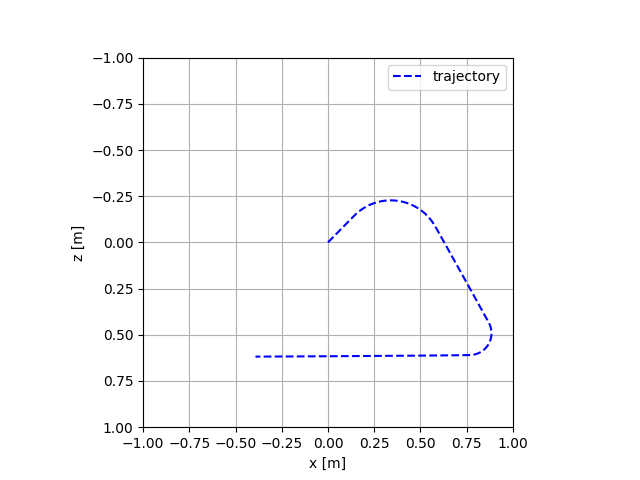

In [18]:
plt.figure()
plt.plot(p[:, 0], p[:, 1], "b--", label="trajectory")
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.grid()
plt.xlim(-1, 1)
plt.ylim(1,-1)
plt.gca().set_aspect("equal")
plt.legend()

In [19]:
# Inputs
t = np.array([])
vel_r = np.array([])
vel_l = np.array([])
dt = 0.1
for vel_item in vel_profile:
    if len(t) == 0:
        tp = np.arange(0, vel_item[0], dt)
    else:
        tp = np.arange(t[-1]+dt, vel_item[0]+t[-1]+dt, dt)
    vr = np.full(len(tp), vel_item[1])
    vl = np.full(len(tp), vel_item[2])
    t = np.append(t, tp)
    vel_r = np.append(vel_r, vr)
    vel_l = np.append(vel_l, vl)

# print(t)
# print(vel_r)
# print(vel_l)


In [20]:
# forward kinematic model
def kmodel(p, t, vr, vl):
    v = 0.5*r*(vr+vl) # Vitesse linéaire du centre du robot / repère fixe
    w = r/(2*b) * (vr - vl) # Vitesse angulaire du centre du robot / repère fixe
    # Valeur de la pose (position et orientation)
    x = p[0]
    y = p[1]
    theta = p[2]

    dxdt = -v * np.sin(theta)
    dzdt = -v * np.cos(theta)
    dodt = w
    dpdt = [dxdt, dzdt, dodt]
    return dpdt


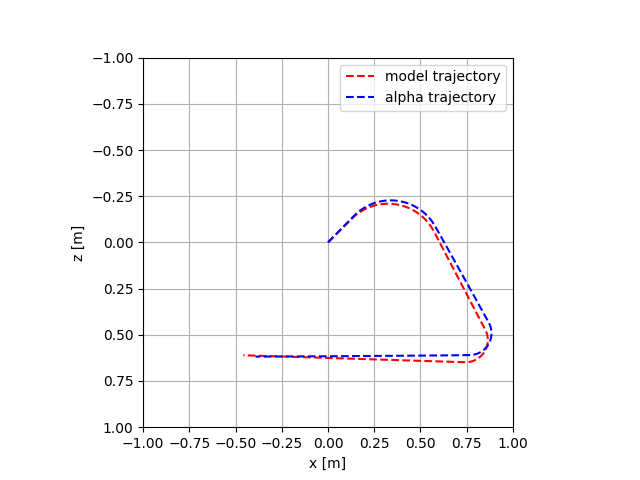

In [21]:
from scipy.integrate import odeint
# initial condition [x0, y0, theta0]
pm0 = p0
pm = np.array(pm0)    # p accumulate x, y and theta values p = [[x,y,theta]]

for i in range(1, len(t)):
    # Espace de temps pour le prochain pas de calcul
    tspan = [t[i-1], t[i]]
    # Résolution pour le prochain pas de calcul
    p_i = odeint(kmodel, pm0, tspan, args=(vel_r[i], vel_l[i]))
    # Stockage des solutions pour le graphique
    pm = np.vstack([pm, p_i[1]])
    # Prochaine condition initiale
    pm0 = p_i[1]
# print(pm)

plt.figure()
plt.plot(pm[:, 0], pm[:, 1], "r--", label="model trajectory")
# plt.plot([0, -np.sin(pm[0, 2])], [0, -np.cos(pm[0, 2])], "g")
plt.plot(p[:, 0], p[:, 1], "b--", label="alpha trajectory")
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.grid()
plt.xlim(-1,1)
plt.ylim(1,-1)
plt.gca().set_aspect("equal")
plt.legend()